In [10]:
%reload_ext autoreload
%autoreload 2

In [11]:
import os
import sys
import matplotlib.pyplot as plt

sys.path.append(os.path.join(os.getcwd(), '..'))

from utils import *
from models import *
from experiments import *

In [12]:
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

In [13]:
def find_best_multitask_run(runs):
    r2_columns = [col for col in runs.columns if 'r2' in col]
    hp_columns = [col for col in runs.columns if ('r2' not in col and 'mse' not in col)]
    # Find max row based on clipped_norm with r2_columns
    best_run = None
    best_r2_vals = 0
    for row in runs.iterrows():
        r2_vals = row[1][r2_columns].values
        if clipped_norm(r2_vals) > clipped_norm(best_r2_vals) if best_r2_vals is not None else 0:
            best_r2_vals = r2_vals
            best_run = row
    best_hps = row[1][hp_columns].values
    return best_run, best_r2_vals, best_hps

def find_best_single_task_runs(runs):
    targets = runs['target'].unique()
    best_runs = {}
    for target in targets:
        target_runs = runs[runs['target'] == target]
        r2_columns = [col for col in target_runs.columns if 'r2' in col]
        hp_columns = [col for col in target_runs.columns if ('r2' not in col and 'mse' not in col and 'target' not in col)]
        # Find max row based on clipped_norm with r2_columns
        best_run = None
        best_r2_vals = 0
        for row in target_runs.iterrows():
            r2_vals = row[1][r2_columns].values
            if clipped_norm(r2_vals) > clipped_norm(best_r2_vals) if best_r2_vals is not None else 0:
                best_r2_vals = r2_vals
                best_run = row
        best_hps = row[1][hp_columns].values
        best_runs[target] = (best_run, best_r2_vals, best_hps)
    return best_runs

In [20]:
def plot_r2_results(title, multitask_norm_path, multitask_no_norm_path, singletask_norm_path, singletask_no_norm_path, rotate=0):
    # Load results data
    multitask_norm = pd.read_csv(multitask_norm_path)
    multitask_no_norm = pd.read_csv(multitask_no_norm_path)
    singletask_norm = pd.read_csv(singletask_norm_path)
    singletask_no_norm = pd.read_csv(singletask_no_norm_path)

    # Process results
    _, best_multitask_norm_r2s, _ = find_best_multitask_run(multitask_norm)
    _, best_multitask_no_norm_r2s, _ = find_best_multitask_run(multitask_no_norm)

    best_single_task_norm_runs = find_best_single_task_runs(singletask_norm)
    best_single_task_no_norm_runs = find_best_single_task_runs(singletask_no_norm)
    
    # Gather best R2s for each target
    targets = singletask_norm['target'].unique()
    best_r2s = {}
    for i, target in enumerate(targets):
        best_r2s[target] = {
            'multitask_norm': best_multitask_norm_r2s[i],
            'multitask_no_norm': best_multitask_no_norm_r2s[i],
            'singletask_norm': best_single_task_norm_runs[target][1][0],
            'singletask_no_norm': best_single_task_no_norm_runs[target][1][0]
        }
    print(f'Best R2s: {best_r2s}')
    # Plotting
    # Create a grouped bar plot with a group for each target, compare best performance for norm and no norm singletask and multitask
    bar_width = 0.2
    x = np.arange(len(targets))
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.bar(x - bar_width, [best_r2s[target]['multitask_norm'] for target in targets], width=bar_width, label='Multi-task Standardized')
    ax.bar(x, [best_r2s[target]['multitask_no_norm'] for target in targets], width=bar_width, label='Multi-task No Standardization')
    ax.bar(x + bar_width, [best_r2s[target]['singletask_norm'] for target in targets], width=bar_width, label='Single-task Standardized')
    ax.bar(x + 2 * bar_width, [best_r2s[target]['singletask_no_norm'] for target in targets], width=bar_width, label='Single-task No Standardization')
    ax.set_xlabel('Targets')
    ax.set_ylabel(r'$R^2$ Score')
    ax.set_title(f'{title} - Comparison of Multi-task and Single-task Models')
    ax.set_xticks(x)
    ax.set_xticklabels(targets)
    # Label the bars with the R2 values
    for i, target in enumerate(targets):
        ax.text(x[i] - bar_width, best_r2s[target]['multitask_norm'], f'{best_r2s[target]["multitask_norm"]:.4f}', ha='center', va='bottom', rotation=rotate)
        ax.text(x[i], best_r2s[target]['multitask_no_norm'], f'{best_r2s[target]["multitask_no_norm"]:.4f}', ha='center', va='bottom', rotation=rotate)
        ax.text(x[i] + bar_width, best_r2s[target]['singletask_norm'], f'{best_r2s[target]["singletask_norm"]:.4f}', ha='center', va='bottom', rotation=rotate)
        ax.text(x[i] + 2 * bar_width, best_r2s[target]['singletask_no_norm'], f'{best_r2s[target]["singletask_no_norm"]:.4f}', ha='center', va='bottom', rotation=rotate)
    ax.legend()
    plt.tight_layout()
    

In [21]:
def get_result_filenames(folder, keyword):
    # Get all files in the folder that contain the keyword
    files = [f for f in os.listdir(folder) if keyword in f]
    return [os.path.join(folder, f) for f in files]

def categorize_exp_files(filenames):
    files = {
        'multitask_norm': [f for f in filenames if 'multitask' in f and 'norm' in f and 'no_norm' not in f],
        'multitask_no_norm': [f for f in filenames if 'multitask' in f and 'no_norm' in f],
        'singletask_norm': [f for f in filenames if 'single_task' in f and 'norm' in f and 'no_norm' not in f],
        'singletask_no_norm': [f for f in filenames if 'single_task' in f and 'no_norm' in f]
    }

    # Sort the files by their creation time
    for key in files:
        files[key].sort(key=lambda x: os.path.getctime(x), reverse=True)
    return files

Best R2s: {'Cd': {'multitask_norm': 0.5452737185914948, 'multitask_no_norm': 0.552654617241473, 'singletask_norm': 0.5393191684186964, 'singletask_no_norm': 0.5393191779566326}, 'Co': {'multitask_norm': 0.6679745786731722, 'multitask_no_norm': 0.6666662042138267, 'singletask_norm': 0.7216449397093337, 'singletask_no_norm': 0.7216449218102079}, 'Cu': {'multitask_norm': 0.694913863109046, 'multitask_no_norm': 0.6919152071662549, 'singletask_norm': 0.7238361751321113, 'singletask_no_norm': 0.7236878323553718}}


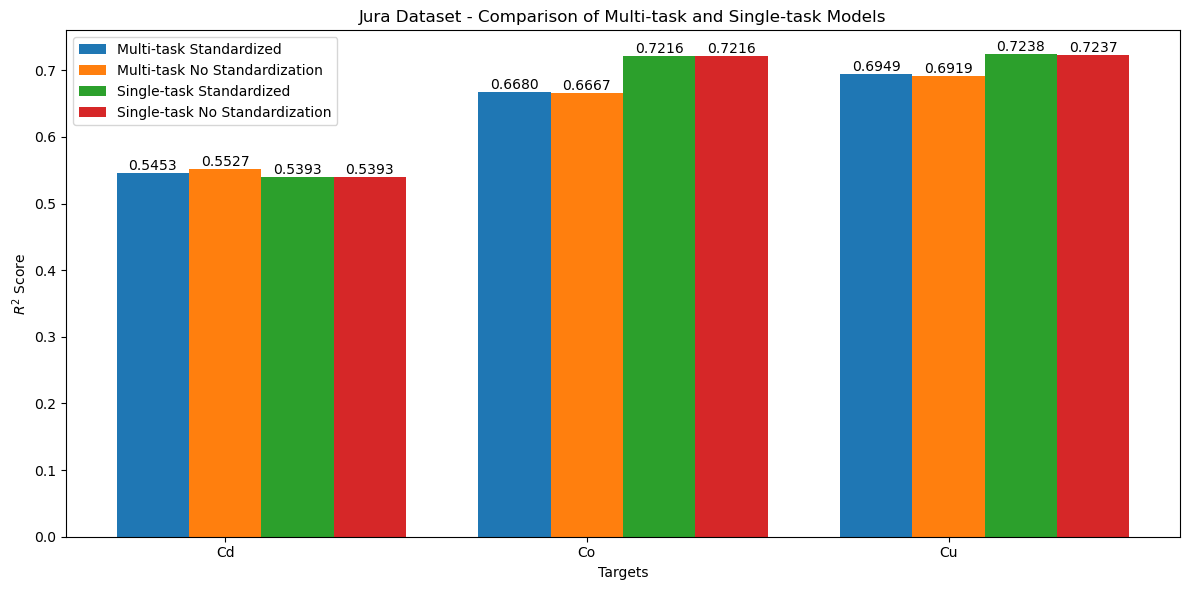

In [22]:
jura_files = get_result_filenames('results', 'jura')
jura_files = categorize_exp_files(jura_files)

plot_r2_results(
    title="Jura Dataset",
    multitask_norm_path=jura_files['multitask_norm'][0],
    multitask_no_norm_path=jura_files['multitask_no_norm'][0],
    singletask_norm_path=jura_files['singletask_norm'][0],
    singletask_no_norm_path=jura_files['singletask_no_norm'][0]
)

Best R2s: {'Y1': {'multitask_norm': 0.998766130136664, 'multitask_no_norm': 0.998722368461665, 'singletask_norm': 0.9987293244171264, 'singletask_no_norm': 0.9987463920422164}, 'Y2': {'multitask_norm': 0.9958350522824124, 'multitask_no_norm': 0.9959383501690732, 'singletask_norm': 0.9955907340942606, 'singletask_no_norm': 0.9955782066229402}}


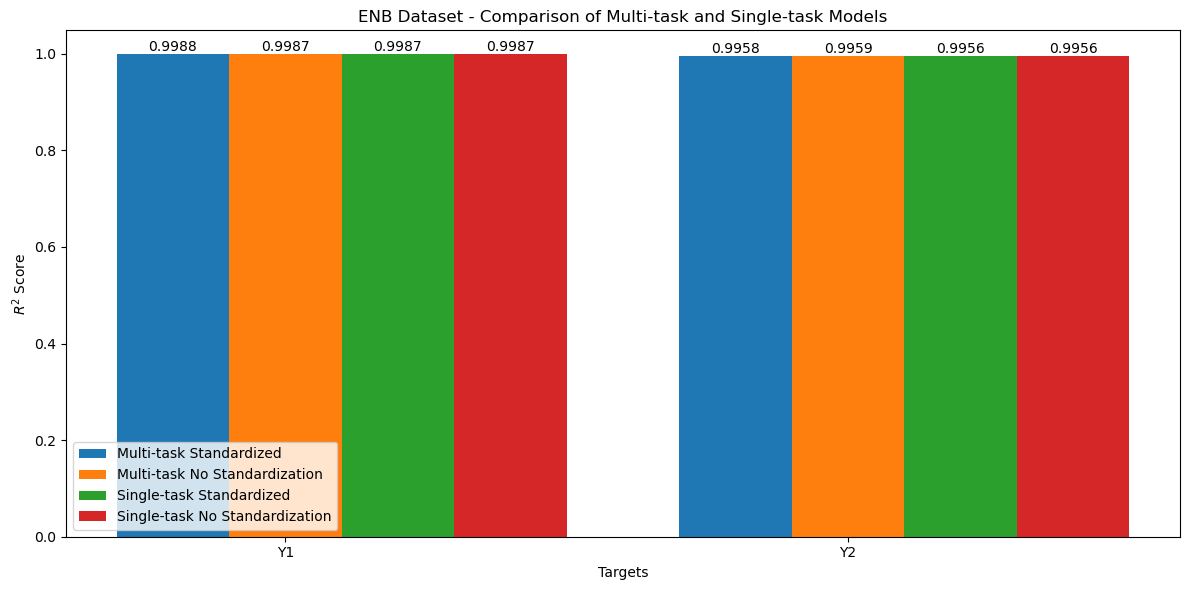

In [23]:
enb_files = get_result_filenames('results', 'enb')
enb_files = categorize_exp_files(enb_files)

plot_r2_results(
    title="ENB Dataset",
    multitask_norm_path=enb_files['multitask_norm'][0],
    multitask_no_norm_path=enb_files['multitask_no_norm'][0],
    singletask_norm_path=enb_files['singletask_norm'][0],
    singletask_no_norm_path=enb_files['singletask_no_norm'][0]
)

Best R2s: {'LBL_ALLminpA_fut_001': {'multitask_norm': 0.8122536899218025, 'multitask_no_norm': 0.8087829, 'singletask_norm': 0.769280012447416, 'singletask_no_norm': 0.7692800164222717}, 'LBL_ALLminp0_fut_001': {'multitask_norm': 0.8520304661999158, 'multitask_no_norm': 0.8504154, 'singletask_norm': 0.832371794625381, 'singletask_no_norm': 0.8323590278625488}, 'LBL_aDLminpA_fut_001': {'multitask_norm': 0.822948982561161, 'multitask_no_norm': 0.82083166, 'singletask_norm': 0.8068843213487213, 'singletask_no_norm': 0.8068843364715577}, 'LBL_aCOminpA_fut_001': {'multitask_norm': 0.9250893309141508, 'multitask_no_norm': 0.9241756, 'singletask_norm': 0.9391036150284752, 'singletask_no_norm': 0.9390464186668396}, 'LBL_aFLminpA_fut_001': {'multitask_norm': 0.8445150845248538, 'multitask_no_norm': 0.84156096, 'singletask_norm': 0.811134085059997, 'singletask_no_norm': 0.8111340999603271}, 'LBL_aUAminpA_fut_001': {'multitask_norm': 0.9265520683050584, 'multitask_no_norm': 0.9255558, 'singletask

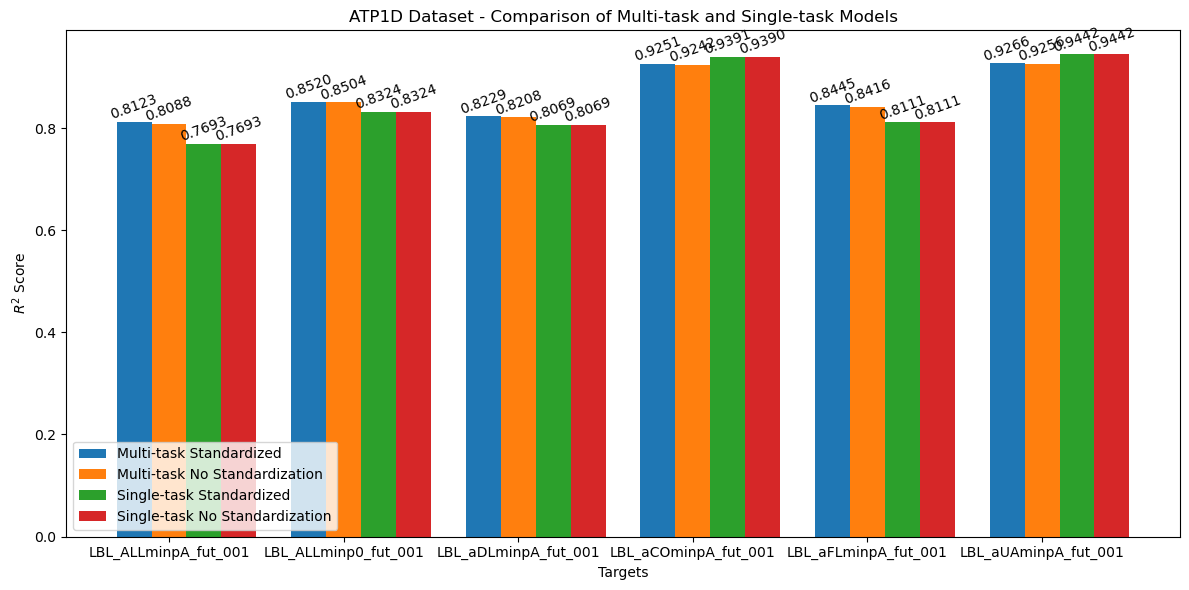

In [24]:
atp1d_files = get_result_filenames('results', 'atp1d')
atp1d_files = categorize_exp_files(atp1d_files)

# TODO: Clean up this plot, not readable atm

plot_r2_results(
    title="ATP1D Dataset",
    multitask_norm_path=atp1d_files['multitask_norm'][0],
    multitask_no_norm_path=atp1d_files['multitask_no_norm'][0],
    singletask_norm_path=atp1d_files['singletask_norm'][0],
    singletask_no_norm_path=atp1d_files['singletask_no_norm'][0],
    rotate=20
)